# Customer Segmentation

Customer segmentation is the process of dividing a broad consumer or business market, typically consisting of existing and potential customers, into sub-groups of consumers based on some type of shared characteristics. These segments are usually defined according to factors such as demographics, behaviors, needs, or other psychographic attributes. The goal is to enable businesses to target specific customer groups more effectively, with tailored marketing, products, or services that meet the unique demands of each segment.


## Libraries

In [ ]:
!pip install mpld3
!pip install scikit-learn==1.6.1

In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
import mpld3
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

## Loading dataset

The dataset consists of 2240 records and 29 features divided into:

- Generic customer information:
    - Year of birth
    - Education level
    - Marital status
    - Income
    - Number of children at home
    - Number of teenagers at home
- The monetary value of products purchased over 2 years
- Information about where the products are sold
- Information about promotions

In [ ]:
data = pd.read_csv("/content/marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## Data Cleaning

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

**Observations:**
- Some values are missing for the INCOME column.
- Not all data are numeric values: EDUCATION, MARITAL_STATUS, DT_CUSTOMER.

In [ ]:
data.select_dtypes(include=['object'])

,Education,Marital_Status,Dt_Customer
0,Graduation,Single,04-09-2012
1,Graduation,Single,08-03-2014
2,Graduation,Together,21-08-2013
3,Graduation,Together,10-02-2014
4,PhD,Married,19-01-2014
...,...,...,...
2235,Graduation,Married,13-06-2013
2236,PhD,Together,10-06-2014
2237,Graduation,Divorced,25-01-2014
2238,Master,Together,24-01-2014


**Missing Data**

Let's remove the rows corresponding to the missing values.

In [ ]:
data = data.dropna().reset_index(drop=True)
data.info()
print("The total number of data-points after removing the rows with missing values are:", len(data))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2216 entries, 0 to 2215
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2216 non-null   int64  
 1   Year_Birth           2216 non-null   int64  
 2   Education            2216 non-null   object 
 3   Marital_Status       2216 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2216 non-null   int64  
 6   Teenhome             2216 non-null   int64  
 7   Dt_Customer          2216 non-null   object 
 8   Recency              2216 non-null   int64  
 9   MntWines             2216 non-null   int64  
 10  MntFruits            2216 non-null   int64  
 11  MntMeatProducts      2216 non-null   int64  
 12  MntFishProducts      2216 non-null   int64  
 13  MntSweetProducts     2216 non-null   int64  
 14  MntGoldProds         2216 non-null   int64  
 15  NumDealsPurchases    2216 non-null   i

**Categorical Data e Date Data**

1) The **Dt_Customer** column indicates the date the user was added to the database. We need to convert this data into a numerical value. Therefore, we will transform all the dates into the number of days, using the minimum and maximum dates in the database as the time reference.

In [ ]:
# finding min e max date to create the time range of data
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], format='%d-%m-%Y')
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)

print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in therecords: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30


In [ ]:
# transforming dates in number of days
days = []
d1 = max(dates)
for i in dates:
    delta = d1 - i
    days.append(int(delta.days))
data["Customer_For"] = days

print(data["Customer_For"])

0       663
1       113
2       312
3       139
4       161
       ... 
2211    381
2212     19
2213    155
2214    156
2215    622
Name: Customer_For, Length: 2216, dtype: int64


2)The columns EDUCATION and MARITAL_STATUS contain labels that need to be converted into numbers. For now, we will just observe how many and what they are, because we will use these for Feature Engineering.

In [ ]:
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


## Feature Engineering

Starting from the basic features in the dataset, we will create new ones in order to increase the explainability of the data. We will introduce the following new columns:

- **AGE**: We will calculate the biological age of the customer based on the birth year provided in the column YEAR_BIRTH.
- **SPENT**: Indicates the total money spent by a customer across different product categories.
- **LIVING_WITH**: Based on the MARITAL_STATUS column, we will indicate whether the customer lives alone or with someone (Partner, Alone).
- **CHILDREN**: Indicates the number of children, both young and adolescent, of the customer.
- **FAMILY_SIZE**: Indicates the total number of family members of the customer.
- **IS_PARENT**: Indicates whether the customer is a parent.
- **EDUCATION**: We will condense this column into three values: Undergraduate, Graduate, and Postgraduate.

In [ ]:
#Age
data["Age"] = 2025-data["Year_Birth"]

#Spent
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Living_With (Partner, Alone)
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Children
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Family size
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Is Parent
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Education: Undergraduate, Graduate, Postgraduate
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#renaming features
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

<ipython-input-60-66fc88a6df51>:14: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Let's remove some redundant features.

In [ ]:
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth"]
data = data.drop(to_drop, axis=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2216 entries, 0 to 2215
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2216 non-null   int64  
 1   Education            2216 non-null   object 
 2   Income               2216 non-null   float64
 3   Kidhome              2216 non-null   int64  
 4   Teenhome             2216 non-null   int64  
 5   Recency              2216 non-null   int64  
 6   Wines                2216 non-null   int64  
 7   Fruits               2216 non-null   int64  
 8   Meat                 2216 non-null   int64  
 9   Fish                 2216 non-null   int64  
 10  Sweets               2216 non-null   int64  
 11  Gold                 2216 non-null   int64  
 12  NumDealsPurchases    2216 non-null   int64  
 13  NumWebPurchases      2216 non-null   int64  
 14  NumCatalogPurchases  2216 non-null   int64  
 15  NumStorePurchases    2216 non-null   i

Let's take a look at the structure of a customer.

In [ ]:
data.iloc[12]

,12
ID,8180
Education,Postgraduate
Income,59354.0
Kidhome,1
Teenhome,1
Recency,53
Wines,233
Fruits,2
Meat,53
Fish,3


## Data Analysis

Before performing data clustering, let's conduct some preliminary analyses to observe its characteristics. This is useful for identifying the presence of outliers, which will later affect the clustering output.

In [ ]:
data.describe()

,ID,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,5588.353339,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,...,0.064079,0.013538,0.009477,0.150271,353.521209,56.179603,607.075361,0.947202,2.592509,0.714350
std,3249.376275,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,...,0.244950,0.115588,0.096907,0.357417,202.434667,11.985554,602.900476,0.749062,0.905722,0.451825
min,0.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,5.000000,0.000000,1.000000,0.000000
25%,2814.750000,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,180.000000,48.000000,69.000000,0.000000,2.000000,0.000000
50%,5458.500000,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,355.500000,55.000000,396.500000,1.000000,3.000000,1.000000
75%,8421.750000,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,...,0.000000,0.000000,0.000000,0.000000,529.000000,66.000000,1048.000000,1.000000,3.000000,1.000000
max,11191.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,...,1.000000,1.000000,1.000000,1.000000,699.000000,132.000000,2525.000000,3.000000,5.000000,1.000000


**Observations:**
- AGE: the maximum age in the dataset is 132, while the average age is 56.
- INCOME: the maximum salary (666,666) is significantly higher than the average salary (52,247.25).

Let's observe the presence of outliers by cross-referencing some of the features present in the dataset: INCOME, RECENCY, CUSTOMER_FOR, AGE, SPENT, IS_PARENT.

Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

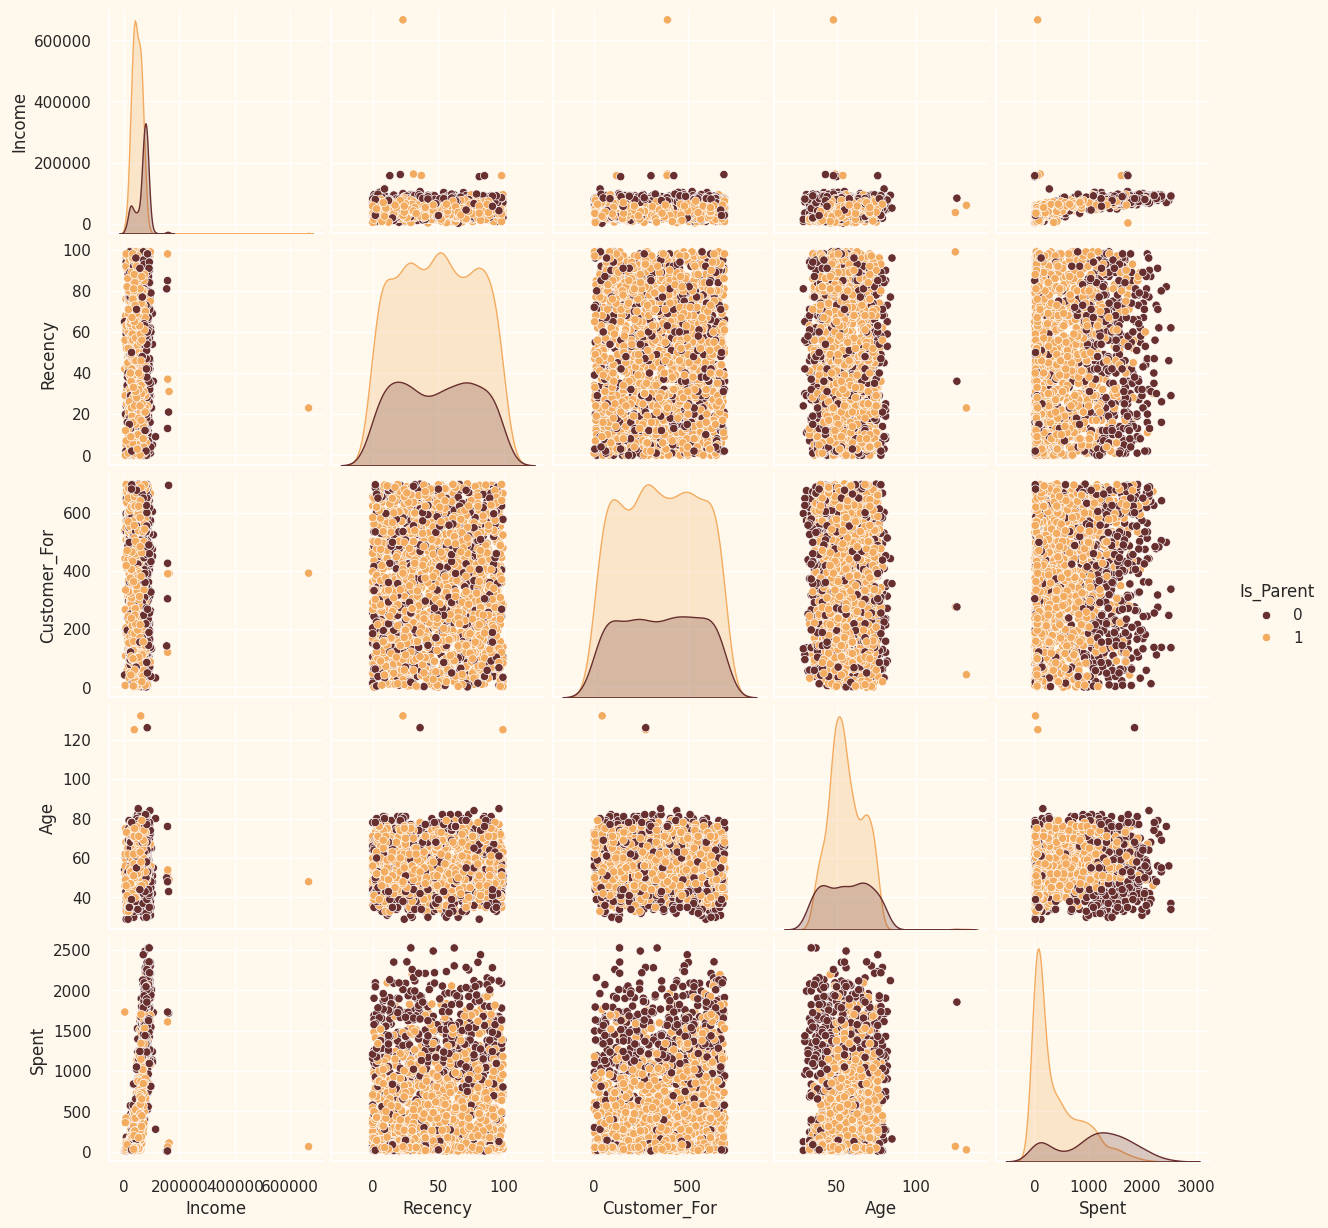

In [ ]:
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))

plt.show()

Some outliers are evident for the INCOME and AGE features, as observed above. Therefore, we will remove these records to increase the consistency of the data.

In [ ]:
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


The last analysis we are going to perform is related to the correlation of the features.

<Axes: >

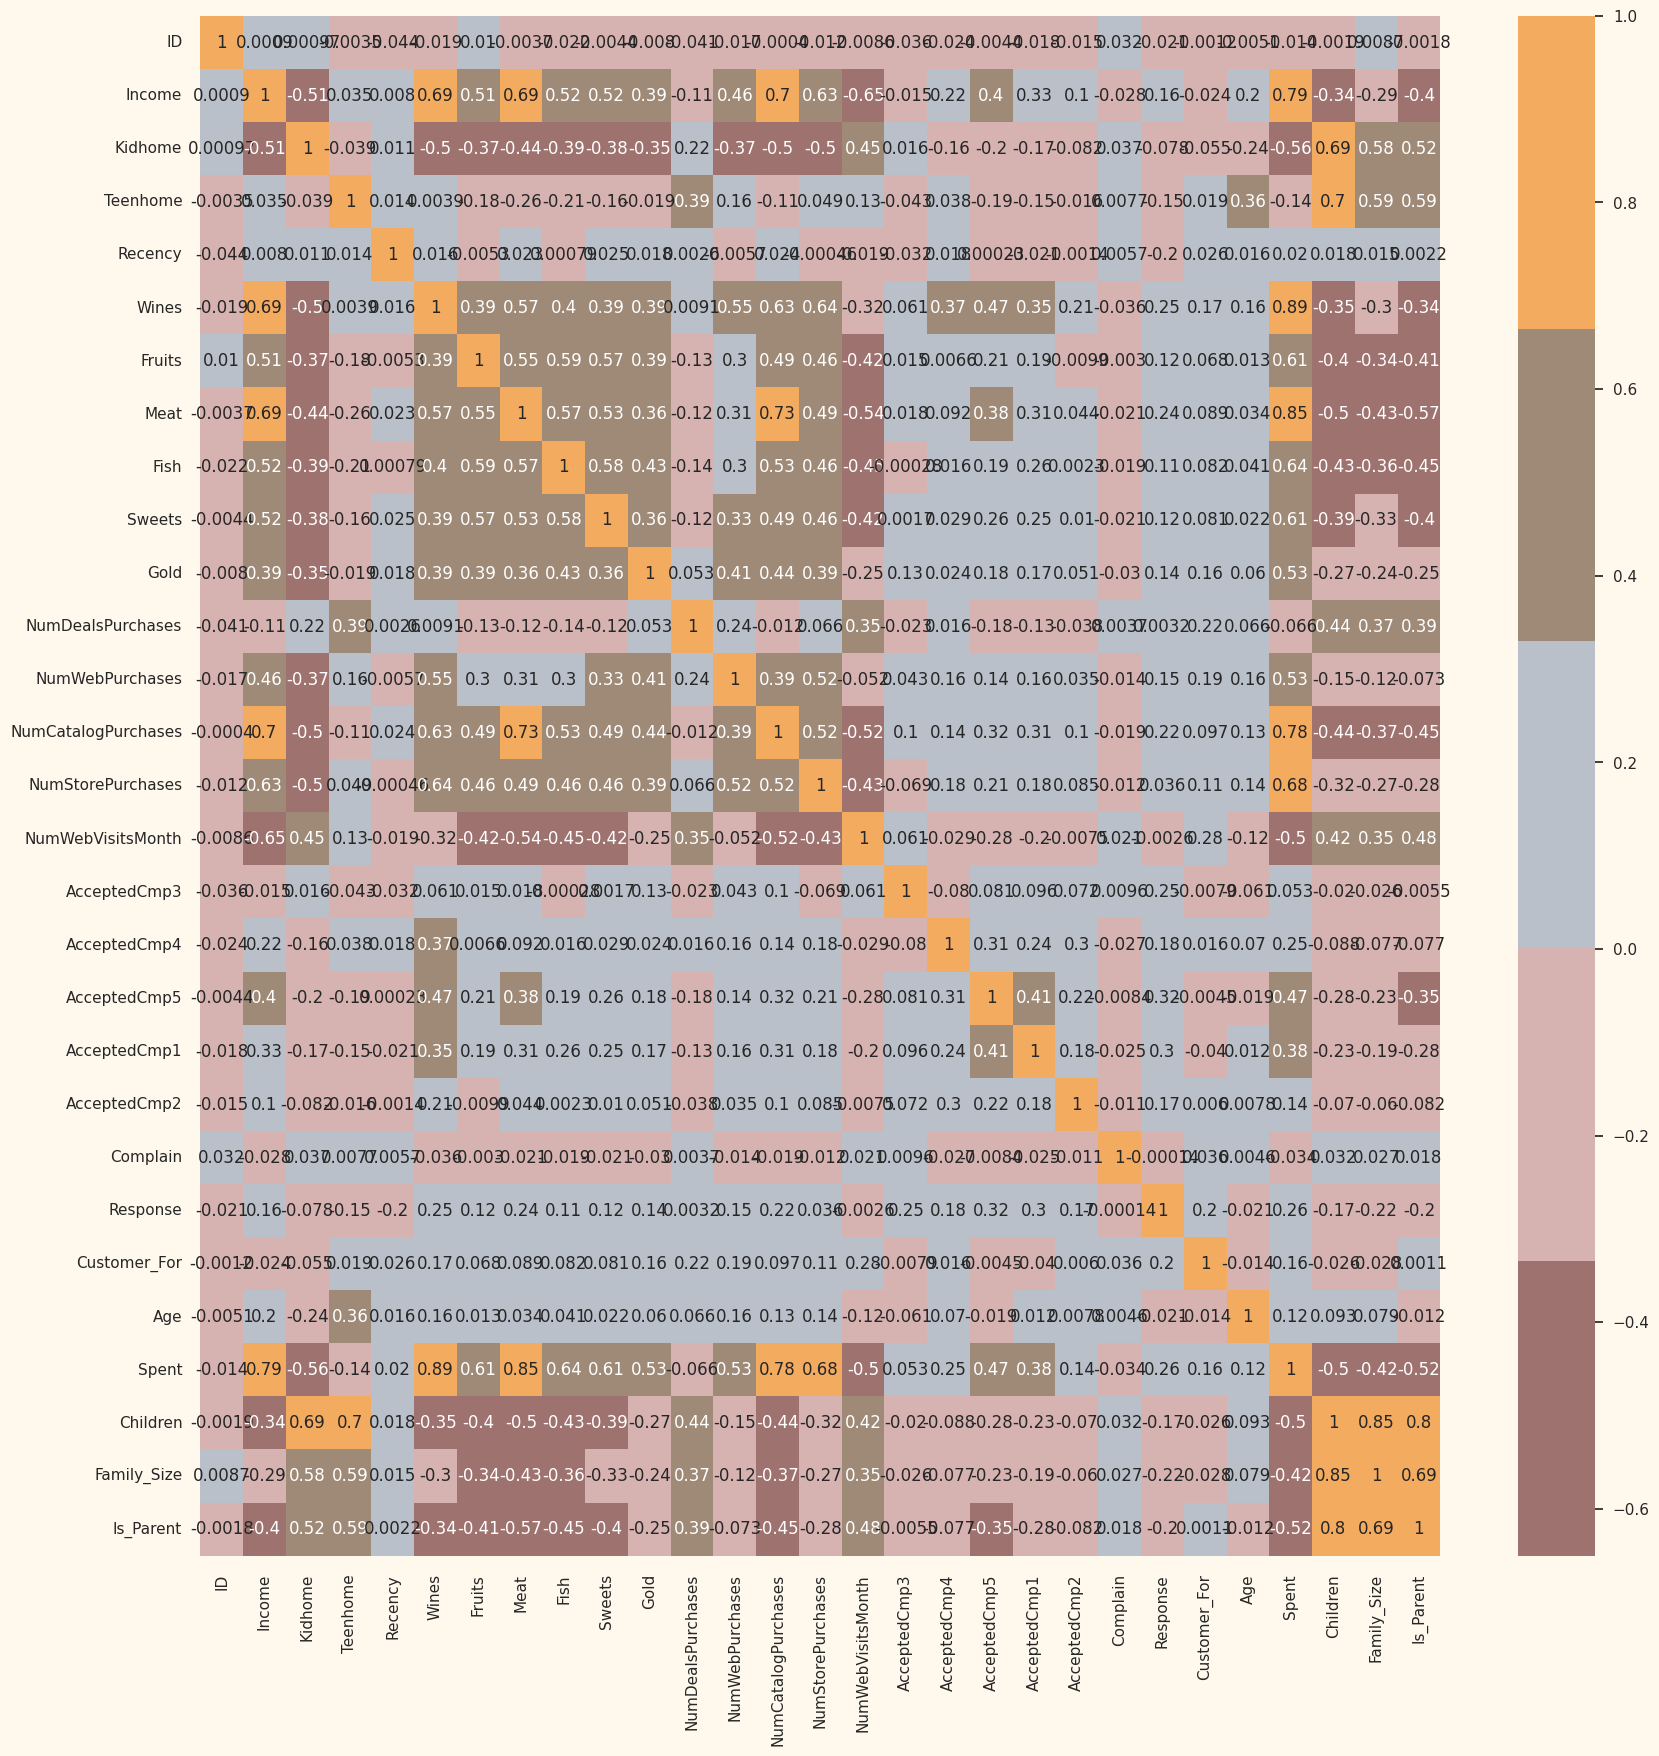

In [ ]:
#correlation matrix
data_corr = data.select_dtypes(exclude=['object'])
corrmat= data_corr.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

Correlation:

*   Negative: the two features are inversely proportional, meaning that as one increases, the other decreases.
*   None: no correlation. The change in one feature does not affect the other.
*   Positive: the two features are proportional, meaning that as the first increases, the second also increases.



## Data Preprocessing

In this phase, we will prepare the data for clustering. We will therefore perform:

- **Label Encoding:** converting all values into numerical values
- **Scaling:** standardizing the values so that they have a distribution with a mean of 0 and a standard deviation of 1


**Label Encoding**

In [ ]:
# let's show the categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [ ]:
#Label Encoding
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)

print("All features are now numerical")
print(data.info())

All features are now numerical
<class 'pandas.core.frame.DataFrame'>
Index: 2212 entries, 0 to 2215
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2212 non-null   int64  
 1   Education            2212 non-null   int64  
 2   Income               2212 non-null   float64
 3   Kidhome              2212 non-null   int64  
 4   Teenhome             2212 non-null   int64  
 5   Recency              2212 non-null   int64  
 6   Wines                2212 non-null   int64  
 7   Fruits               2212 non-null   int64  
 8   Meat                 2212 non-null   int64  
 9   Fish                 2212 non-null   int64  
 10  Sweets               2212 non-null   int64  
 11  Gold                 2212 non-null   int64  
 12  NumDealsPurchases    2212 non-null   int64  
 13  NumWebPurchases      2212 non-null   int64  
 14  NumCatalogPurchases  2212 non-null   int64  
 15  NumStorePurc

In [ ]:
# deleting redundant features
ds = data.copy()
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response', "ID"]
ds = ds.drop(cols_del, axis=1)

**Scaling**

In [ ]:
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


## Clustering
The data is ready, let's perform the clustering analysis by applying the K-Means algorithm. To find the best partition, we will vary the parameter k and use the Elbow method.

In [ ]:
model = KMeans()

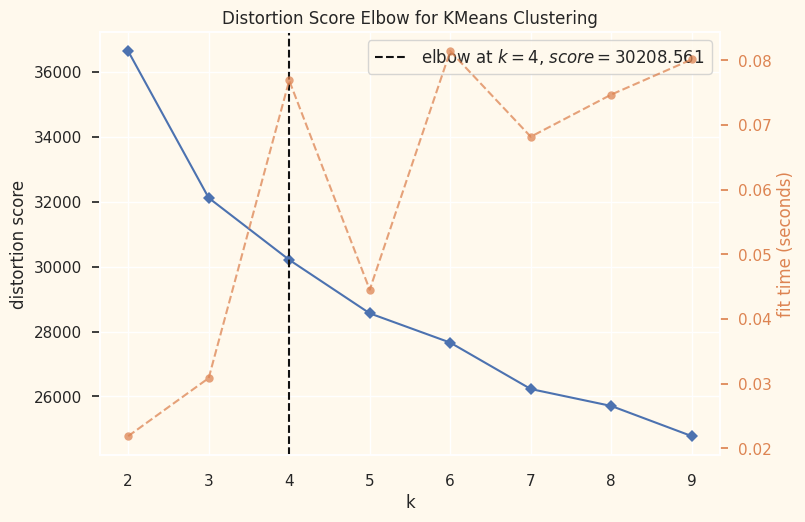

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
d_visualizer = KElbowVisualizer(model, k=(2,10), metric='distortion')
d_visualizer.fit(scaled_ds)
d_visualizer.show()

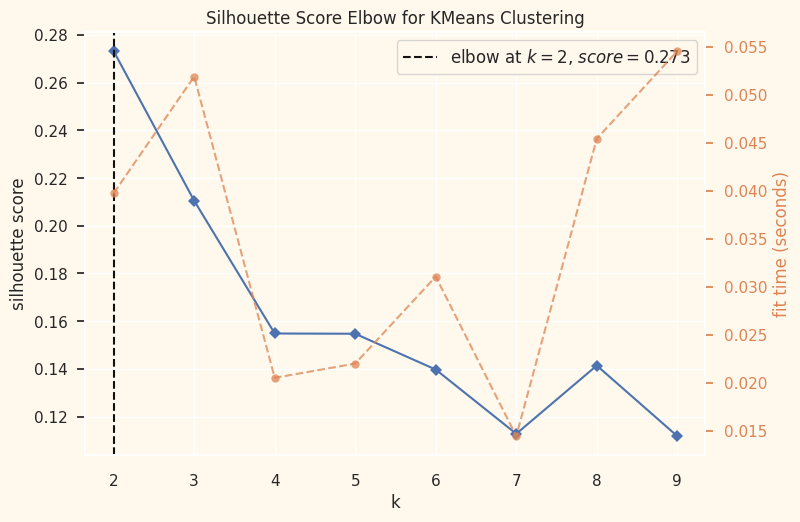

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
s_visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')
s_visualizer.fit(scaled_ds)
s_visualizer.show()

In [ ]:
# apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_ds)

# adding cluster labels to dataframe
scaled_ds['Cluster'] = kmeans_labels

In [ ]:
scaled_ds.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent,Cluster
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139,0
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456,3
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,1.290224,-0.544908,-0.206048,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139,0
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456,1
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456,1


**Dimensionality Reduction**


We reduce the number of features in order to plot the data in 2 dimensions.

In [ ]:
# apply PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(scaled_ds)
pca_df = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
pca_df['Cluster'] = kmeans_labels

**Cluster Plot**

In [ ]:
import plotly.express as px

# adding some feature to pca dataframe
pca_df['Age'] = data['Age']
pca_df['Income'] = data['Income']
pca_df['Is_Parent'] = data['Is_Parent']
pca_df['Is_Parent'] = data['Is_Parent']
pca_df['Living_With'] = data['Living_With']


# create plot
fig = px.scatter(pca_df, x="PC1", y="PC2", color="Cluster",
                 hover_data=["Age", "Income", "Is_Parent","Living_With"])
fig.show()

## Evaluation

<ipython-input-79-ec0c7baf2863>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




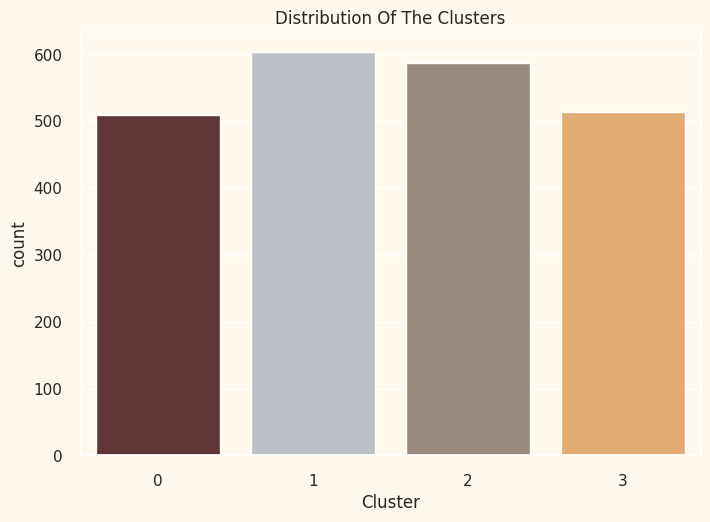

In [ ]:
# plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=scaled_ds["Cluster"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

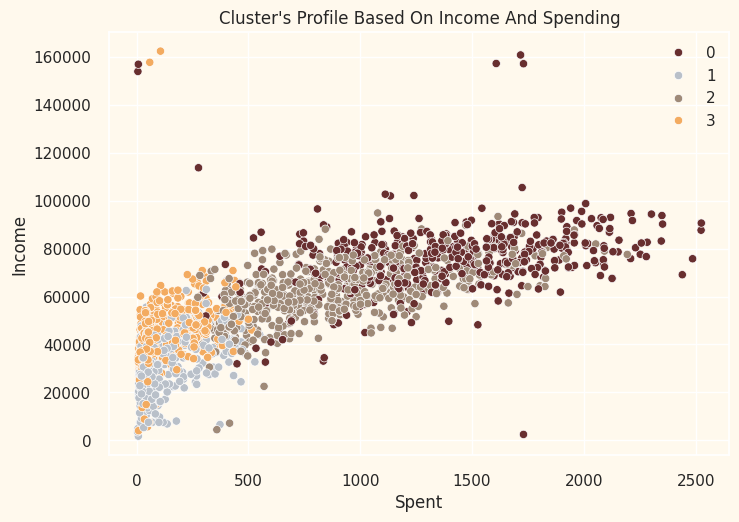

In [ ]:
# plotting Income vs Spent cluster data
ds["Cluster"] = kmeans_labels
pl = sns.scatterplot(data = ds,x=ds["Spent"], y=ds["Income"],hue=ds["Cluster"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

**Income vs spending plot shows the clusters pattern**


- cluster 0: high spending & high income
- cluster 1: low spending & low income
- cluster 2: average spending & average income
- cluster 3: low spending & average income


